# Predicting Gold Price with Univariate Time Series Forecasting

-Capstone Project-

* Student: Graham Wilson
* Instructor: Victor Geislinger 
* Cohort: ds-ft-041320

## Overview

**Background**

2020 has been a year of multiple uncertainties mainly driven by the onset and aftermath of the COVID-19 pandemic that has disrupted daily activity for nearly everybody in multiple ways. For one, the global economic impact of such a destructive force has been easily observed and well documented throughout this year. This includes, but is not limited to, a plethora businesses shuttering doors, millions of individuals out of work, unpaid rents, delinquent mortgages, negative gas prices, and bare store shelves. The list goes on.

The Federal Reserves response was to inject whatever amount of stimulus money into the system (trillions so far in this fiscal year alone) it would take to prop up a failing economy. That said, precious metals have been a historic safe haven for investors during times of increasing volatility and future uncertainty. Most notably, it provides a hedge against the debasement of fiat currency, while preserving the value of ones wealth.

As the Federal Reserve continues to dilute the value of the American Dollar, many are fleeing for alternative investments outside of the current system; this typically starts with the flight into gold and gold assets, then trickles down to silver along with other precious metals and hard assets. The influx of open interest has already been seen in 2020 with gold reaching all time nominal highs of over $2000/oz in August of this year. 

**Focus**

An investment firm has been closely watching the global economic turmoil unravel, and is interested in allocating a percentage of their capital into gold to take advantage of the current precious metals bull market. They're interested in where the price of gold could go over the next year to determine near term risk and reward potential.

This analysis aims to use a Time Series modeling technique known as ARIMA (Auto-regressive Inegrated Moving Average) to as accurately as possible predict the price of an ounce of gold between August 2020 and January of 2022.

**Data**

Gold prices are set twice a day (A.M. and P.M.) by the London Bullion Market and are based in nominal U.S. dollars starting from 1968 up to the present. Data for gold prices used in this project are located on the Federal Reserves website (https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM), and a copy is located in the project folder named 'GOLDAMGBD228NLBM.csv'.

# Obtain Data

In [169]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from pandas import Grouper
from pandas.plotting import lag_plot
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import itertools
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.gofplots import qqplot

from math import log, exp, sqrt


import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data as a series and set the index to datetime
series = pd.read_csv('GOLDAMGBD228NLBM.csv', header=0, index_col=0, 
                          parse_dates=True, squeeze=True)
series.head(50)

DATE
1968-04-01    38.000
1968-04-02    37.600
1968-04-03    37.700
1968-04-04    36.700
1968-04-05    37.200
1968-04-08    37.000
1968-04-09    37.250
1968-04-10    37.600
1968-04-11    38.050
1968-04-12         .
1968-04-15         .
1968-04-16    38.100
1968-04-17    38.000
1968-04-18    37.600
1968-04-19    37.650
1968-04-22    38.300
1968-04-23    38.050
1968-04-24    38.350
1968-04-25    38.250
1968-04-26    38.500
1968-04-29    38.550
1968-04-30    39.100
1968-05-01    39.100
1968-05-02    39.250
1968-05-03    39.600
1968-05-06    39.700
1968-05-07    39.300
1968-05-08    39.500
1968-05-09    39.700
1968-05-10    39.800
1968-05-13    39.400
1968-05-14    39.600
1968-05-15    40.100
1968-05-16    40.850
1968-05-17    41.600
1968-05-20    42.000
1968-05-21    42.600
1968-05-22    42.200
1968-05-23    41.500
1968-05-24    41.750
1968-05-27    41.500
1968-05-28    41.600
1968-05-29    41.500
1968-05-30    41.750
1968-05-31    42.000
1968-06-03         .
1968-06-04    41.200
1968-06-

In [3]:
series.describe()

count     13665
unique     7729
top           .
freq        423
Name: GOLDAMGBD228NLBM, dtype: object

In [4]:
series.index

DatetimeIndex(['1968-04-01', '1968-04-02', '1968-04-03', '1968-04-04',
               '1968-04-05', '1968-04-08', '1968-04-09', '1968-04-10',
               '1968-04-11', '1968-04-12',
               ...
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14'],
              dtype='datetime64[ns]', name='DATE', length=13665, freq=None)

* From the initial data load, the data appears be indexed in datetime format, contains 13665 observations, with some null values marked with '.'. The data type is also listed as an object; the null values and the data type must be addressed during the data preparation phase.

# Scrub Data

In [6]:
#Replace periods with null values
series.replace(to_replace='.', value=np.nan, inplace=True)

In [7]:
#Change data type to float
gold_series = pd.to_numeric(series, downcast='float')

In [8]:
#Forward fill null values
gold_series.ffill(inplace=True)

In [9]:
gold_series.head(20)

DATE
1968-04-01    38.000000
1968-04-02    37.599998
1968-04-03    37.700001
1968-04-04    36.700001
1968-04-05    37.200001
1968-04-08    37.000000
1968-04-09    37.250000
1968-04-10    37.599998
1968-04-11    38.049999
1968-04-12    38.049999
1968-04-15    38.049999
1968-04-16    38.099998
1968-04-17    38.000000
1968-04-18    37.599998
1968-04-19    37.650002
1968-04-22    38.299999
1968-04-23    38.049999
1968-04-24    38.349998
1968-04-25    38.250000
1968-04-26    38.500000
Name: GOLDAMGBD228NLBM, dtype: float32

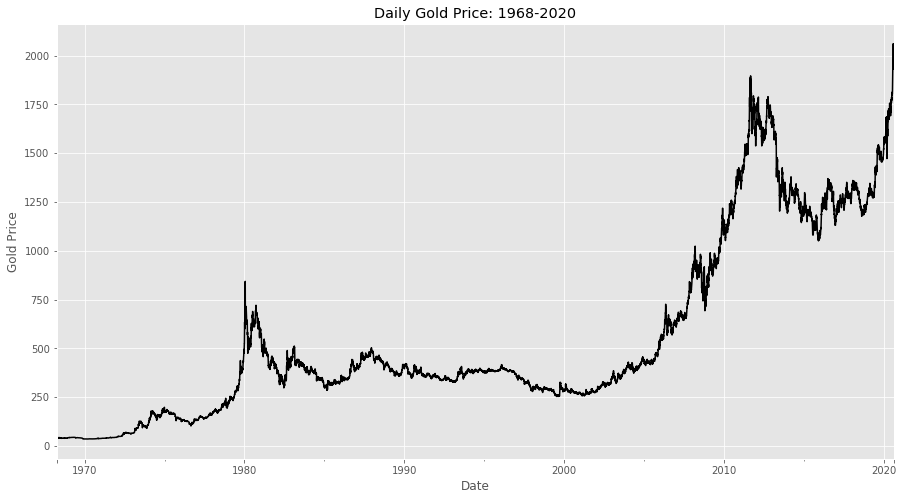

In [144]:
#Visualize data
gold_series.plot(figsize=(15, 8), color='black')
plt.title('Daily Gold Price: 1968-2020')
plt.xlabel('Date')
plt.ylabel('Gold Price');

* The initial line plot visualization reveals an overall upward trend of the gold price, as well as significant periods of volatility. Both must be taken into consideration during the modeling process.

# Data Exploration

* One assumption for time series modeling is that the data should have a Gaussian distribution for more accurate results. This can be visualized using a histogram plot.

## Plots

### KDE

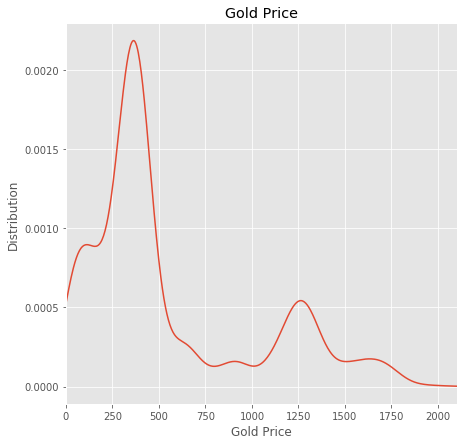

In [11]:
#Visualize the histogram of price distribution
plt.figure(figsize=(7, 7))
gold_series.plot(kind='kde')
plt.xlim([0, 2100])
plt.title('Gold Price')
plt.xlabel('Gold Price')
plt.ylabel('Distribution');

* An initial look at the kde plot reveals that distributions of gold price are clearly not Gaussian. In fact, there seems to be a bimodal distribution heavily skewed toward the left. This means that some type of transform should be performed on the data to ensure it fits with time series assumptions.

### Boxplot

* Grouping the data by year and visualizing the box plots may help get an idea of the spread of gold price annually and how it may be changing over time. 

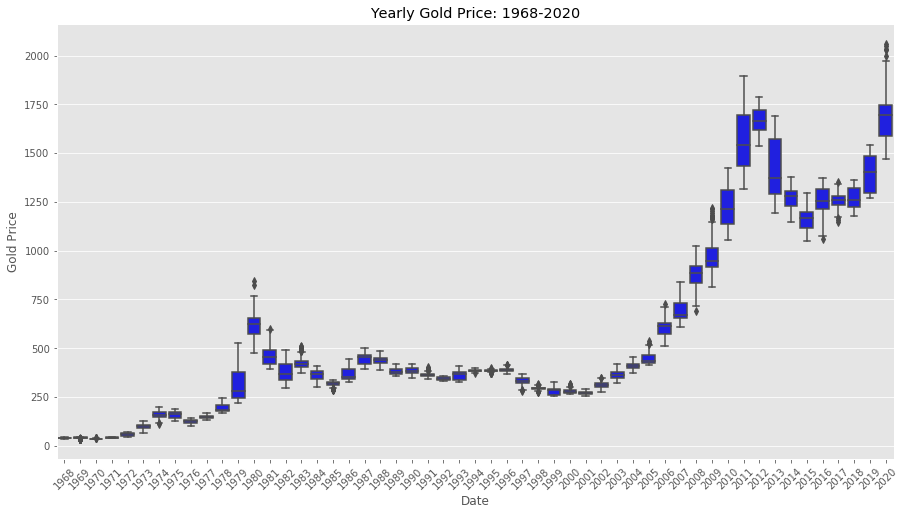

In [139]:
#Group prices by year and visualize results as boxplot
plt.figure(figsize= (15, 8))
fig = seaborn.boxplot(gold_series.index.year, gold_series, color='b')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Yearly Gold Price: 1968-2020');

* Box plot observations reveal two major periods of high volatility and price variance between 1979-1982 and 2006-present. The majority of years show a very different signature of low volatility and variance. It's possible that prices prior to 2000 may not be beneficial for forecasting and can possibly be clipped prior to modeling.

### Lag Plot

* Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag1, the observation at two time steps ago lag=2, and so on.


* If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.

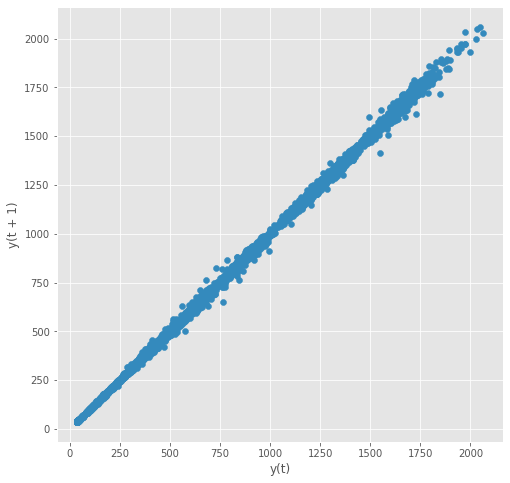

In [13]:
#Visualize lag plot relationship
plt.figure(figsize=(8,8))
lag_plot(gold_series);

* As expected, a quick look at the lag1 plot suggests a string, positive correlation between observations. This indicates some level of differencing must occur during the modeling process.

## Stationarity Check

* Time series modeling for accurate forecasting requires the data to be stationary. This is achieved when the statistical properties of mean, variance, and covariance remain constant over time. Stationarity can be tested in a variety of ways, however in this case the Dickey-Fuller test will be used. The null hypothesis for this test assumes that the provided data are not stationary. To reject the null hypothesis and confirm that the data are stationary, the test statistics must be less than the critical value of p < 0.05. 

In [14]:
#Create data frame from the series to run Dickey-Fuller test
gold_df = pd.DataFrame(gold_series)
gold_df.rename(columns = {'GOLDAMGBD228NLBM' : 'daily_gold_price'}, inplace=True)
gold_df = gold_df.asfreq('B')
gold_df.index


DatetimeIndex(['1968-04-01', '1968-04-02', '1968-04-03', '1968-04-04',
               '1968-04-05', '1968-04-08', '1968-04-09', '1968-04-10',
               '1968-04-11', '1968-04-12',
               ...
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14'],
              dtype='datetime64[ns]', name='DATE', length=13665, freq='B')

In [15]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13665 entries, 1968-04-01 to 2020-08-14
Freq: B
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   daily_gold_price  13665 non-null  float32
dtypes: float32(1)
memory usage: 160.1 KB


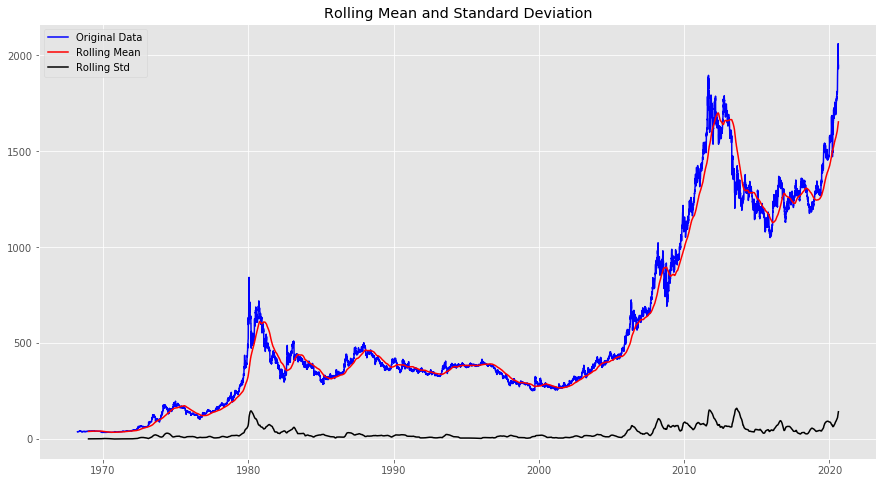

Dickey-Fuller Test Results: 

Test Statistic              1.222952
p-value                     0.996141
#Lags                      41.000000
#Observations           13623.000000
Critical Value (1%)        -3.430830
Critical Value (5%)        -2.861752
Critical Value (10%)       -2.566883
dtype: float64


In [16]:
def stationarity_check(ts):
    
    
    roll_mean = ts.rolling(window=200, center=False).mean()
    roll_std = ts.rolling(window=200, center=False).std()
    
    dftest = adfuller(ts.iloc[:, 0])
    
    fig = plt.figure(figsize=(15, 8))
    og = plt.plot(ts, color='blue', label='Original Data')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test Results: \n')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value',
                                              '#Lags', '#Observations'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


stationarity_check(gold_df)

* From the above graph, neither the mean nor the standard deviation are constant. Also, the p-value of the Dickey-Fuller test is well above the 0.05 threshold; this confirms that the gold data are not stationary, and as confirmed by the above graphs, must be transformed prior to modeling.

## Decomposition

* Another visual check is to  use time series decomposition which splits the time series data into three different components: seasonal, trend, and residuals. This makes it easy to visualize whether or not time series data are stationary and ready to model. Having already performed the dickey-fuller test, it is assumed at this will return what is already known - that the series is not stationary. However, these visualizations will help isolate trends and seasonality in a visual format. 

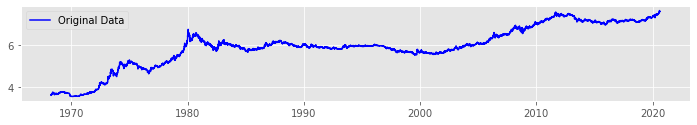

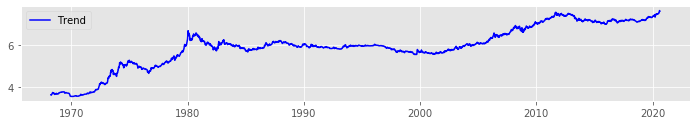

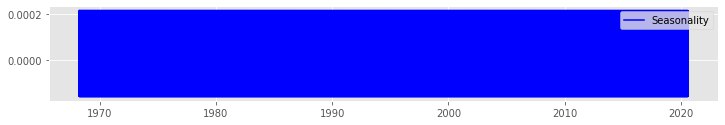

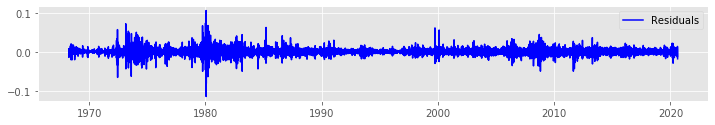

In [17]:
#Apply seasonal decompose with a log transform
decomposition = seasonal_decompose(np.log(gold_df))

#Get trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


#Plot results
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(np.log(gold_df), label='Original Data', color='blue')
plt.legend()

plt.figure(figsize=(12, 8))
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend()

plt.figure(figsize=(12, 8))
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend()

plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend();

* The seasonality component of the daily gold price seems to be non existent based off the above graph. So, it's safe to rule out any model that takes into account seasonality such as SARIMA.

# Models

## Baseline Model

* Prior to manipulating the data, or getting into analysis, it's good practice to establish a baseline level performance known as a naive forecast in time series modeling. This provides the lowest benchmark for future model evaluation. 



* With this naive forecast, observations from the previous time step are used as the prediction for the next observed time step.

In [21]:
#Prep data. Split gold values into 75% train 25% test samples
X = gold_series.values
X = X.astype('float32')
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:]

#step forward validation
history = [x for x in train]
predictions = list()


for t in range(len(test)):
    #make prediction
    yhat = history[-1]
    predictions.append(yhat)
    #observation
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
    
#report performance   
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=664.00, expected=663.00
predicted=663.00, expected=667.50
predicted=667.50, expected=667.25
predicted=667.25, expected=663.15
predicted=663.15, expected=667.75
predicted=667.75, expected=673.00
predicted=673.00, expected=676.00
predicted=676.00, expected=683.50
predicted=683.50, expected=682.75
predicted=682.75, expected=677.25
predicted=677.25, expected=675.40
predicted=675.40, expected=663.50
predicted=663.50, expected=661.50
predicted=661.50, expected=666.75
predicted=666.75, expected=660.25
predicted=660.25, expected=665.35
predicted=665.35, expected=666.35
predicted=666.35, expected=674.15
predicted=674.15, expected=669.25
predicted=669.25, expected=670.40
predicted=670.40, expected=670.85
predicted=670.85, expected=664.50
predicted=664.50, expected=669.85
predicted=669.85, expected=667.35
predicted=667.35, expected=665.00
predicted=665.00, expected=664.15
predicted=664.15, expected=653.00
predicted=653.00, expected=658.50
predicted=658.50, expected=655.50
predicted=655.

predicted=1086.50, expected=1085.00
predicted=1085.00, expected=1091.35
predicted=1091.35, expected=1094.80
predicted=1094.80, expected=1113.25
predicted=1113.25, expected=1116.80
predicted=1116.80, expected=1117.35
predicted=1117.35, expected=1116.75
predicted=1116.75, expected=1117.30
predicted=1117.30, expected=1119.15
predicted=1119.15, expected=1123.20
predicted=1123.20, expected=1137.95
predicted=1137.95, expected=1149.35
predicted=1149.35, expected=1153.50
predicted=1153.50, expected=1154.25
predicted=1154.25, expected=1134.40
predicted=1134.40, expected=1128.50
predicted=1128.50, expected=1125.50
predicted=1125.50, expected=1125.50
predicted=1125.50, expected=1141.90
predicted=1141.90, expected=1140.00
predicted=1140.00, expected=1130.05
predicted=1130.05, expected=1125.00
predicted=1125.00, expected=1121.00
predicted=1121.00, expected=1120.85
predicted=1120.85, expected=1122.30
predicted=1122.30, expected=1107.75
predicted=1107.75, expected=1106.35
predicted=1106.35, expected=

* The baseline model achieved an RMSE of 14.114. The lower the RMSE value (closer to 0), the better. Moving forward, achieving a value below 14.114 means a better model than the baseline has been established for forecasting gold prices.

## ARIMA Model

As mentioned in the overview, ARIMA stands for AutoRegressive Integrated Moving Average. 

* The AR portion of the model uses the dependent relationship between an observation and some number of lagged observations and is denoted by the variable 'p'.
* The MA model uses the dependency between an observation and a residual error from a moving average model applies to lagged observations and is denoted by the variable 'q'.
* I uses the differencing of raw observations in order to make sure the time series is stationary. It is denoted by the variable 'd'.

The grid search process can be used to determine optimal (p, d, q) orders for an accurate time series forecast of future gold price. This is done by running through all of the possible model combinations for the provided variables eventually providing insight into the most favorable ARIMA model parameters.

### ARIMA Model Grid Search

In [16]:
# #evaluate arima model for (p, d q) orders
# def arima_eval(X, arima_order):
#     #prepare train-test data
#     train_size = int(len(X)*0.75)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
    
#     #predictions
#     preds= list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit(disp=0, )
#         yhat=model_fit.forecast()[0]
#         preds.append(yhat)
#         history.append(test[t])
        
#     #calc root mean squared error
#     rmse = sqrt(mean_squared_error(test, preds))
#     return rmse

In [ ]:
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     rmse = arima_eval(dataset, order)
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,rmse))
#                 except:
#                     continue
                    
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# p_values = range(0, 4)
# d_values = range(1, 4)
# q_values = range(0, 4)

# evaluate_models(gold_series.values, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=14.112


* The above code ran for 20hrs. This is somewhat perplexing, but a different approach must be used to save time. 


* As it seems that any data before 2000 may not be helpful in predicting gold prices, it's possible the data might not be needed. Try cutting down on the amount of data being run through the grid search - anything before the year 2000, and switch to SARIMAX and aic as the indicator of a good model fit.

#### Split time series to dates later than 2000

In [22]:
#Create new dataframe with gold values from 2000 to present
gold_df_2000 = gold_df['2000-01-01':]
gold_df_2000.rename(columns = {'GOLDAMGBD228NLBM' : 'daily_gold_price'}, inplace=True)
gold_df_2000.head()

,daily_gold_price
DATE,
2000-01-03,290.850006
2000-01-04,282.049988
2000-01-05,282.100006
2000-01-06,280.350006
2000-01-07,282.000000


In [23]:
gold_df_2000.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5380 entries, 2000-01-03 to 2020-08-14
Freq: B
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   daily_gold_price  5380 non-null   float32
dtypes: float32(1)
memory usage: 63.0 KB


In [25]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [28]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(gold_df_2000,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {}: AIC Calculated ={}'.format(comb, output.aic))
    except:
        continue

ARIMA (0, 0, 0): AIC Calculated =90304.32173297262
ARIMA (0, 0, 1): AIC Calculated =82887.48887038803
ARIMA (0, 0, 2): AIC Calculated =76101.59623954078
ARIMA (0, 0, 3): AIC Calculated =70727.08093553047
ARIMA (0, 1, 0): AIC Calculated =41633.91706789702
ARIMA (0, 1, 1): AIC Calculated =41628.81103358658
ARIMA (0, 1, 2): AIC Calculated =41624.042637504215
ARIMA (0, 1, 3): AIC Calculated =41618.498430259715
ARIMA (0, 2, 0): AIC Calculated =45397.19220968491
ARIMA (0, 2, 1): AIC Calculated =41626.384633991256
ARIMA (0, 2, 2): AIC Calculated =41620.88530992932
ARIMA (0, 2, 3): AIC Calculated =41616.1282998924
ARIMA (0, 3, 0): AIC Calculated =51307.525196430055
ARIMA (0, 3, 1): AIC Calculated =45391.87502070921
ARIMA (0, 3, 2): AIC Calculated =42532.08788374976
ARIMA (0, 3, 3): AIC Calculated =42338.84769152092
ARIMA (1, 0, 0): AIC Calculated =41640.54080452256
ARIMA (1, 0, 1): AIC Calculated =41634.781698704646
ARIMA (1, 0, 2): AIC Calculated =41630.02563877117
ARIMA (1, 0, 3): AIC Calcul

In [34]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (3, 1, 3)
aic      41602.3
Name: 55, dtype: object

* The ARIMA model with pdq values of (3, 1, 3) have generated the most optimal modeling parameters with the given information. A low AIC score indicates a better model, with a score of 41602 this may mean even the best model night not generate meaningful results for forecasting gold prices. 

### ARIMA Model with (3, 1, 3) parameters

* Test the model performance on optimal pdq parameters selected using the test data

In [26]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.SARIMAX(gold_df_2000, order=(3, 1, 3))

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4399      0.011    -39.613      0.000      -0.462      -0.418
ar.L2         -0.4407      0.011    -39.348      0.000      -0.463      -0.419
ar.L3         -0.9628      0.011    -90.548      0.000      -0.984      -0.942
ma.L1          0.4367      0.011     41.311      0.000       0.416       0.457
ma.L2          0.4290      0.011     39.777      0.000       0.408       0.450
ma.L3          0.9721      0.010     99.346      0.000       0.953       0.991
sigma2       134.6114      0.977    137.813      0.000     132.697     136.526


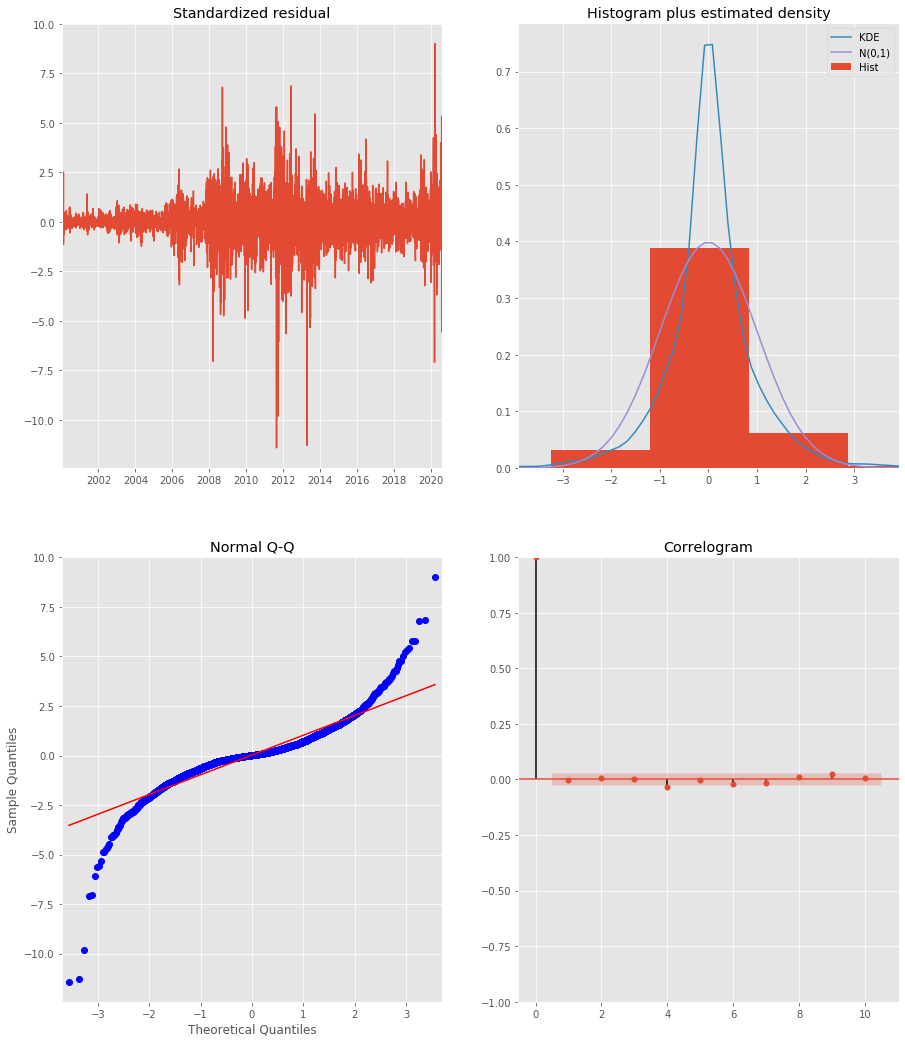

In [27]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

* P-values in the above table are all lower than the 0.05 threshold for indicating stationarity, however the Q-Q plot of the residuals do not follow a linear trend towards either end of the plot. This may be due to the fact that gold prices go from relatively stable closer to 2000 to highly volatile as time progresses. This can be observed in the standardized residual graph above.

# Model Evaluation, Predictions, and Forecasts

## One Step Ahead Forecasting

* Although a one-step ahead forecast was used during the baseline modeling process, the optimal parameters were not used. So, it's prudent to run a new model with updated pdq orders to see if any accuracy improvements have been made through modeling.

In [127]:
#Split data into 75% train, 25% test samples and get start and end dates for both.
X = gold_df_2000['daily_gold_price']
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

In [128]:
train

DATE
2000-01-03     290.850006
2000-01-04     282.049988
2000-01-05     282.100006
2000-01-06     280.350006
2000-01-07     282.000000
                 ...     
2015-06-15    1178.250000
2015-06-16    1182.099976
2015-06-17    1178.500000
2015-06-18    1198.000000
2015-06-19    1198.150024
Freq: B, Name: daily_gold_price, Length: 4035, dtype: float32

In [129]:
test

DATE
2015-06-22    1193.699951
2015-06-23    1183.349976
2015-06-24    1175.750000
2015-06-25    1174.599976
2015-06-26    1174.400024
                 ...     
2020-08-10    2030.300049
2020-08-11    1996.599976
2020-08-12    1931.699951
2020-08-13    1931.000000
2020-08-14    1948.300049
Freq: B, Name: daily_gold_price, Length: 1345, dtype: float32

* After splitting the data into 75% train and 25% test sets, there are 4035 observations in the training set and 1345 observations in the test set.

In [175]:
#Set values and split data into test and train sets 
model = sm.tsa.SARIMAX(gold_df_2000, order=(3,1,3), trend='t',
                       filter_concentrated=True)
output = model.fit()
    
# Get predictions for test and train data
# Dynamic set to False to ensure one-step ahead forecasting
pred_test = output.get_prediction(start='2015-06-22', end='2020-08-14', dynamic=False)
pred_train = output.get_prediction(start='2000-01-03', end='2015-06-19')
    
pred_conf = pred_test.conf_int()

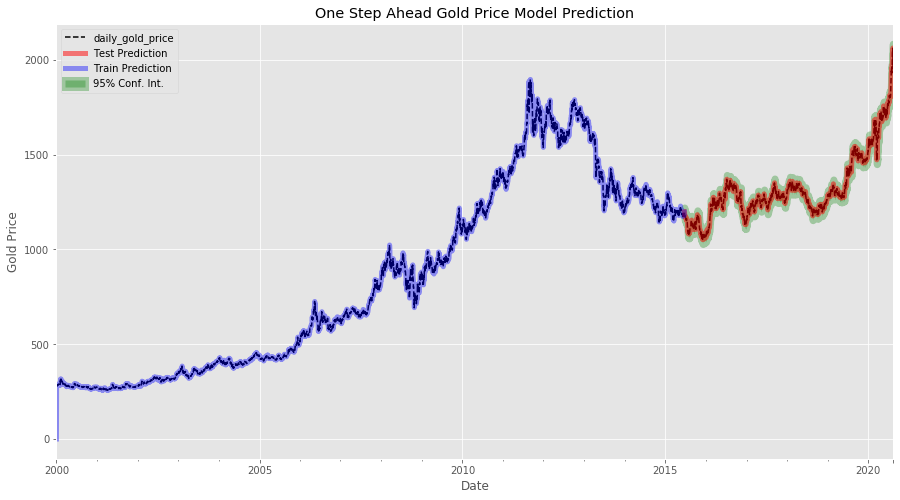

In [198]:
#Plot model predictions vs observations
plt.rcParams["figure.figsize"] = [15, 8]

#Observations
ax = gold_df_2000.plot(color='black', style='--')

#Predictions
pred_test.predicted_mean.plot(
    ax=ax, label='Test Prediction', alpha=.5, color='red', lw=5)
pred_train.predicted_mean.plot(ax=ax, label='Train Prediction', alpha=0.4, color='blue', lw=5)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=.3, label='95% Conf. Int.',
                lw=7)

#Set labels
ax.set_xlabel('Date')
ax.set_ylabel('Gold Price')
plt.legend(loc=2)
plt.title('One Step Ahead Gold Price Model Prediction');

* The one-step ahead forecast aligns with the test values as seen in the above graph. However, it's difficult to see that the predictions are shifted one day into the future from the the observations. It may be easier to see at a different scale.

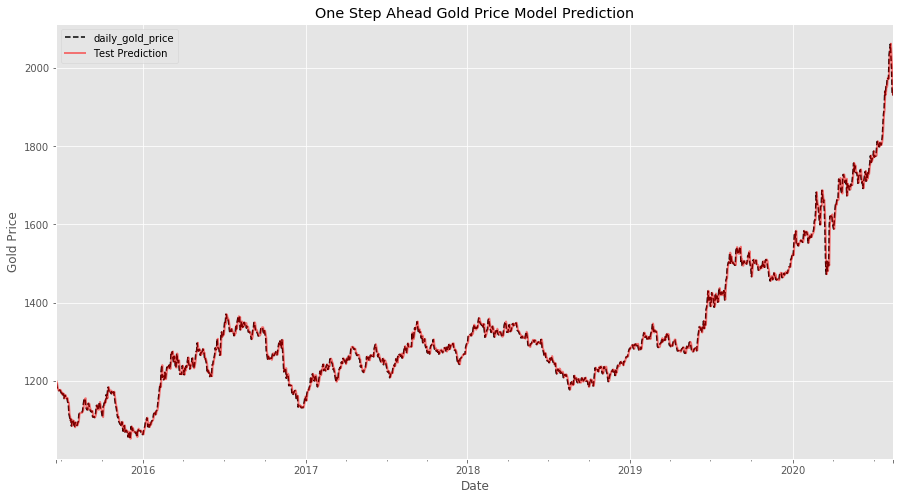

In [195]:
#Plot model predictions vs observations
plt.rcParams["figure.figsize"] = [15, 8]

#Observations
ax = gold_df_2000['2015-06-22':'2020-08-14'].plot(color='black', style='--')

#Predictions
pred_test.predicted_mean.plot(
    ax=ax, label='Test Prediction', alpha=.5, color='red', lw=2)


#Set labels
ax.set_xlabel('Date')
ax.set_ylabel('Gold Price')
plt.legend(loc=2)
plt.title('One Step Ahead Gold Price Model Prediction');

* Again, it's difficult to see the shift in the forecast, but looking closely these two lines do not match up perfectly.

* Check to see if the (3, 1, 3) ARIMA model has improved the rmse.

In [132]:
# Get the predicted values
gold_forecasted = pred_test.predicted_mean

#Compute rmse
rmse = np.sqrt(((gold_forecasted - test) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 11.66


* This model improved the rmse by 3, from 14 to 11.Though, this is an improvement, it may not be statistically significant from the baseline model. Especially for the amount of time and computational power it took compared to the first iteration.

## Dynamic Forecasting

* Looking deeper into  the model will provide more insight into the true predictive power of the generated model. This can be achieved through dynamic forecasting where only information from the time series up to a certain point is used, and after that, forecasts are predicted using values from the previous forecast. 

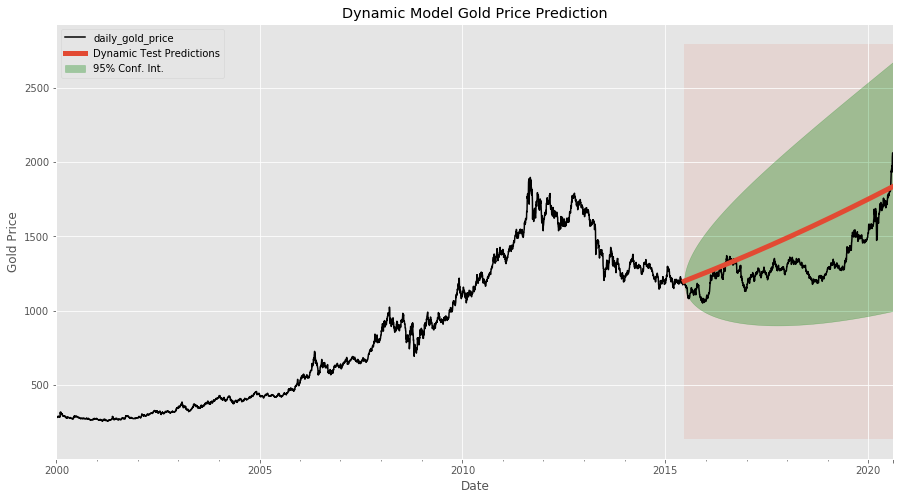

In [148]:
#Generate dynamic predictions
pred_dynamic = output.get_prediction(start='2015-06-22', end='2020-08-14', dynamic=True, 
                                    full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

#Plot results
ax = gold_df_2000.plot(label='observed', figsize=(15, 8), color='black')
pred_dynamic.predicted_mean.plot(label='Dynamic Test Predictions', ax=ax, lw=5)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3, label='95% Conf. Int.')

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-22'), gold_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Gold Price')
plt.legend(loc=2)
plt.title('Dynamic Gold Price Model Prediction')

plt.show()

* Though the dynamic forecast captures the upward trend of gold prices between 2015 and today, the fluctuation and volatility seen in the test set is not captured. 
* This result could come from a few different issues:

     * The provided data have no associated detectable trend or seasonality -- lack of complexity
     * Inappropriate use of modeling parameters leading to a disruption in trend and seasonality detection      
     * With only a single variable, ARIMA models have a hard time accounting for volatility
     * Undetected seasonal component to data due to data sampling interval


* These issues will need to be addressed in subsequent model iterations to provide more accurate forecasting of gold price.

## One Year Future Forecasting

* Although the predicted dynamic forecasts don't properly reflect the test set, it would still be appropriate to visualize the one year into the future forecast to get a general sense of where gold prices could go if it follows the same upward trend.

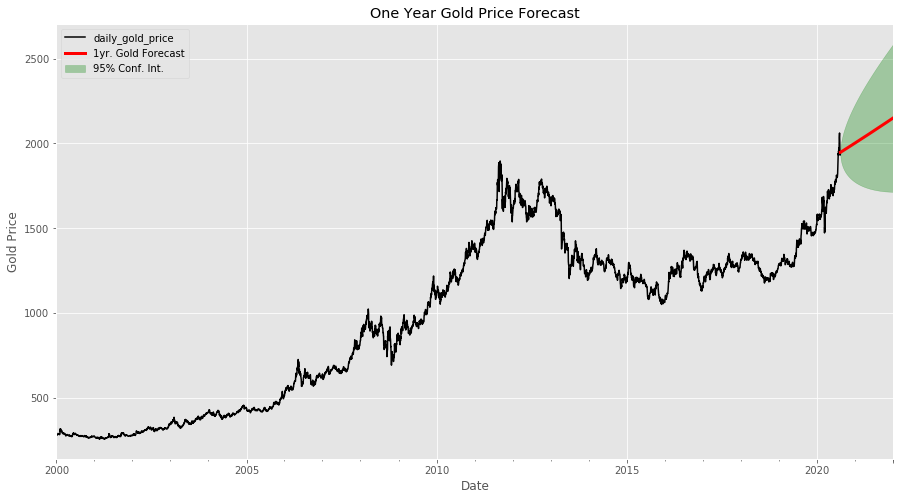

In [202]:
#Generate predictions 1yr into the future
prediction = output.get_forecast(steps=365)
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = gold_df_2000.plot(label='observed', figsize=(15, 8), color='black')
prediction.predicted_mean.plot(ax=ax, label='1yr. Gold Forecast', color='red', 
                              lw=3)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.3, label='95% Conf. Int.')
ax.set_xlabel('Date')
ax.set_ylabel('Gold Price')

plt.title("One Year Gold Price Forecast")
plt.legend(loc=2)
plt.show()

* Again as expected, the gold price volatility is not captured and a straight line with an upward trend is projected one year into the future. However, the forecast isn't all for nothing, the confidence interval can provide insight into the upper and lower limits of future gold prices. These limits alone can help furnish the starting point for the extend of risk versus reward for near term gold investing.

## Potential Limits of One Year ROI

In [209]:
#Visualise limits of confidence interval 1 year into the future
pred_conf.tail(10)

,lower daily_gold_price,upper daily_gold_price
2021-12-27,1714.884939,2577.701069
2021-12-28,1714.857777,2578.885101
2021-12-29,1714.831563,2580.068385
2021-12-30,1714.806295,2581.250927
2021-12-31,1714.781968,2582.432728
2022-01-03,1714.758580,2583.613793
2022-01-04,1714.736125,2584.794125
2022-01-05,1714.714602,2585.973728
2022-01-06,1714.694006,2587.152605
2022-01-07,1714.674335,2588.330759


In [210]:
#Mean 1yr future gold price
(2588.33+1714.67)/2

2151.5

* The lower limit gold forecast of 365 business days into the future is 1714.67, while the upper limit is 2588.33. The mean price is 2151.50

* The spot gold price as of 9/17/2020 is 1952.84

In [216]:
upper_roi = round(((2588.33 - 1952.84) / 1952.84)*100, 2)
lower_roi = round(((1714.67 - 1952.84) / 1952.84)*100, 2)
mean_roi = round(((2151.50 - 1952.84) / 1952.84)*100, 2)

print(f"Potential upper limit ROI: {upper_roi}%")
print(f"Potential lower limit ROI: {lower_roi}%")
print(f"Potential average ROI: {mean_roi}%")

Potential upper limit ROI: 32.54%
Potential lower limit ROI: -12.2%
Potential average ROI: 10.17%


* If one were to invest a percentage of their portfolio in gold using the current forecast, the model projects a potential 1 year ROI of as high as 32.54% and a potential loss of -12.2%, with an average ROI of 10.17%. At first glance, these numbers seem to deliver promising returns, though it's important to remember volatility is not captured in this model. 

In [4]:
#Find ROI for 1968-2020, 2000-2020, 2016-2020
tot = round(((2000 - 38) / 38)*100, 2)
tot_2000 = round(((2000 - 260) / 260)*100, 2)
tot_2016 = round(((2000 - 1072) / 1072)*100, 2)
print(tot)
print(tot_2000)
print(tot_2016)

5163.16
669.23
86.57


## Yearly Seasonal Plots: 2000-2019

* Is there any sort of annual seasonality in gold price if the data are resampled into monthly averages?

* Is there a more opportune time of year to buy/sell gold for maximum profitability?


* The year 2020 will be dropped since the year has not yet finished.

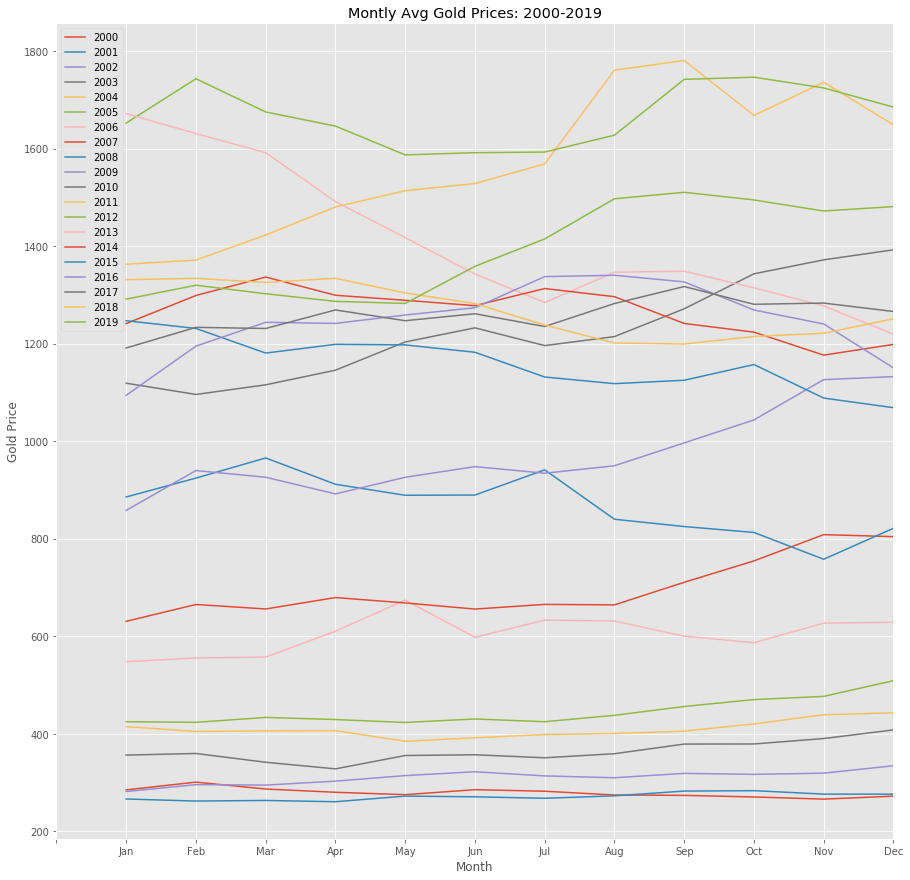

In [171]:
#Drop the year 2020 and resample gold prices to monthly means
years = gold_df_2000['2000-01-01':'2019-12-31']
monthly_mean = years.resample('M').mean()

#Group gold prices by year
year_groups = monthly_mean.groupby(pd.Grouper(freq = 'A'))

# Create new df and store yearly values in columns
annual_gold = pd.DataFrame()


for yr, group in year_groups:
    annual_gold[yr.year] = group.values.ravel()
   
annual_gold.index = range(1,len(annual_gold)+1)

#Plot results
annual_gold.plot(figsize=(15, 15), subplots=False)
plt.xlim(1, 12)
plt.xticks(np.arange(13), ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                      'Sep', 'Oct', 'Nov', 'Dec'])

plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.title('Montly Avg Gold Prices: 2000-2019')
plt.legend(loc=2)
plt.show()

* At first glance, there's no clear seasonality to gold price fluctuations; there are too many factors influencing the price of gold year over year. However, years after 2008 may show a rough uptick in gold prices during the later summer months, then a drop in prices toward the end of the year. If one were to use this quick look to try and profit from gold price fluctuations, one should purchase gold later in the year (December), and sell by the end of summer (September).

# Conclusion

Having used the ARIMA model for time series analysis on predicting future gold prices, it's clear from the lack of captured volatility in the results that further model refinement must be performed or an entirely different modeling technique should be implemented.


The first issue that arose was lengthy computational time during the grid search model selection process. This was dealt with by cutting down the amount of data being analyzed. Since the behavior of gold had a different signature (low volatility) prior to the year 2000, prices were cut down to only include years from 2000 to today.


Running a grid search on the slimmed down data found the optimal pdq modeling parameters to be ARIMA(3, 1, 3). After modeling, the measured p-values indicated the data was stationary, however residual plots showed the model had trouble accounting for the extreme volatility in gold price seen in recent years. This was confirmed when forecasted values graphed as a smooth upward trending line. This could be due to a variety of issues:

 * The provided data have no associated detectable trend or seasonality -- lack of complexity
 * Inappropriate use of modeling parameters leading to a disruption in trend and seasonality detection      
 * With only a single variable, ARIMA models have a hard time accounting for volatility
 * Undetected seasonal component to data due to data sampling interval

One positive is that the model captured the current upward trend of gold prices. Using the confidence interval around the forecasted gold price can provide insight into the upper and lower limits of future gold prices. These limits alone can help furnish the starting point for the extend of risk versus reward for near term gold investing.

Current model 1 year gold price predictions using gold price as of 9/17/2020 (1952.48):
  * Lower limit ROI (1714.67) - -12.2%
  * Average ROI (2151.50) - 10.17%
  * Upper limit ROI (2588.33) - 32.54%

The current model reveals there's more upside potential than downside risk in investing a portion of a portfolio into the gold sector. This can help hedge against market volatility and currency debasement.

#  Recommendations

Computing power was a major limitation during the modeling process. This greatly increase modeling computational time and may have hindered the models ability to find the most optimal parameter orders for an accurate forecast. It's recommended to invest in more powerful hardware to decrease computational time while increasing the ability for to search more thoroughly for optimal modeling parameters.


The ARIMA modeling technique may not be the correct selection for this specific task. It had a difficult time predicting the volatility of gold price seen in more recent years. One possible solution is to try different models that specifically account for more variance in price action such as the Autoregressive Conditional Heteroskedasticity (ARCH) method. The ARCH model is specifically designed to take into account volatility by modeling residual error variance at each step in time. 


The value of gold is widely known to be influenced by many factors including: inflation rates, U.S. dollar strength, investment demand, mine supply, central bank purchases, and overall economic sentiment. Forecasting gold may be too complex of a problem for univariate time series modeling. Therefore, switching to a multivariate time series method could more accurately predict volatility and capture the momentum of gold either to the up or the down side.

Increasing computing power while exploring more complex modeling techniques will yield better forecasting results which will better aid investors to make a more informed decision on allocating a percentage of their portfolio to exposure in the gold space.